# Train model on encoded data

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from collections import deque
import pandas as pd
import math


import sys
sys.path.append('..')
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.is_available()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay
)
from collections import deque
import pandas as pd
import math


import sys
sys.path.append('..')
from slp_package.input_dataset_old import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.is_available()

True

In [2]:
def asses_model(
    model_name, 
    y_pred, 
    y_test, 
    labels_order, 
    plot_roc=False
):
    """
    Assess a classification model using multiple metrics, confusion matrices,
    classification report, and optional ROC curve visualization.

    Parameters:
    -----------
    model_name : str
        The name of the model to display in plots.
    y_pred : array-like
        Model predictions.
    y_test : array-like
        True labels.
    labels_order : list
        Labels in a specific order you want for confusion matrices and bar charts.
    plot_roc : bool, default = False
        Whether to plot the ROC curves (for binary or multi-class classification).
    """

    # --- 1. Metrics: Accuracy & Cohen Kappa ---
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    print(f'\nModel: {model_name}')
    print(f'Accuracy:          {accuracy:.4f}')
    print(f'Cohen Kappa Score: {kappa:.4f}')

    # --- 2. Classification Report ---
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels_order))

    # --- 3. Over/Under Prediction Bar Chart ---
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    normalized_counts_pred = {
        k: v / counts_test[np.where(unique_test == k)[0][0]] 
        for k, v in zip(unique_pred, counts_pred)
        if k in unique_test
    }

    # Calculate the percent the model over or under predicted the labels 
    # using the specified label order
    sorted_values = [
        normalized_counts_pred[k] - 1 
        if k in normalized_counts_pred 
        else 0 
        for k in labels_order
    ]

    plt.figure(figsize=(2*len(labels_order), 8))
    plt.bar(labels_order, sorted_values,
            color=['green' if x > 0 else 'blue' for x in sorted_values])
    plt.title(f'Percent Model {model_name} Over/Under Predicted Labels', fontsize=50)
    plt.xlabel('Labels', fontsize=40)
    plt.ylabel('Over/Under', fontsize=40)
    # make the x-ticks bigger and vertical
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    # Center y-axis
    max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
    plt.ylim(-max_extent, max_extent)
    plt.axhline(y=0, color='gray', linewidth=0.8)
    plt.show()

    # --- 4. Confusion Matrices (Not Normalized, Normalized by True, Normalized by Pred) ---
    for norm in [None, 'true', 'pred']:
        plt.figure(figsize=(len(labels_order)+5, len(labels_order)+5))
        ax = plt.gca()
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, 
            labels=labels_order,
            normalize=norm, 
            xticks_rotation='vertical', 
            ax=ax
        )
        title_str = 'Not Normalized' if norm is None else f'Normalized by {norm}'
        ax.set_title(f'{model_name} Confusion Matrix ({title_str})', fontsize=40)
        ax.set_xlabel('Predicted Label', fontsize=30)
        ax.set_ylabel('True Label', fontsize=30)
        # make the y an x ticks bigger
        ax.yaxis.set_tick_params(labelsize=20)
        ax.xaxis.set_tick_params(labelsize=20)
        plt.tight_layout()
        plt.show()

    # --- 5. (Optional) Plot ROC Curves ---
    if plot_roc:
        # This approach can work for both binary and multi-class problems
        # For multi-class, we do one-vs-rest
        try:
            # Convert labels to one-hot encoding for multi-class
            # If you already have binary labels (0,1) or one-hot encoding, adjust accordingly.
            from sklearn.preprocessing import label_binarize
            n_classes = len(labels_order)
            y_test_binarized = label_binarize(y_test, classes=labels_order)
            y_pred_binarized = label_binarize(y_pred, classes=labels_order)

            plt.figure(figsize=(8, 6))
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, 
                         label=f'Class {labels_order[i]} (AUC = {roc_auc:.2f})')
            
            # Micro-average ROC curve
            fpr_micro, tpr_micro, _ = roc_curve(
                y_test_binarized.ravel(), 
                y_pred_binarized.ravel()
            )
            roc_auc_micro = auc(fpr_micro, tpr_micro)
            plt.plot(fpr_micro, tpr_micro,
                     label=f'Micro-average (AUC = {roc_auc_micro:.2f})',
                     linestyle='--', color='black')

            plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=30)
            plt.ylabel('True Positive Rate', fontsize=30)
            plt.title(f'{model_name} ROC Curves', fontsize=40)
            plt.legend(loc='lower right')
            plt.show()

        except Exception as e:
            print(f"Could not plot ROC curves: {e}")


In [3]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True],
}
player_features = {
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    'type_name': ['HUMAN']
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}

# We will not be training with a label.
label_info = {
    'source': ['player'], # Can be 'general', 'player
    'feature': ['character_name']
}

In [4]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)
dataset.dataset.head()

/workspace/slp_jaspar/autoencoder_revised/../slp_package/input_dataset_old.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
0,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\727e819f-8cb3-4c3f-bf0a-ceefa9e41c...,5606,FALCO
1,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\76fe3db5-60de-46bb-8f0d-80d48822a8...,5754,FALCO
2,POKEMON_STADIUM,2,True,MARTH,HUMAN,HUMAN,mango\MARTH\7e6b417f-249d-4629-b6dc-2fe1d95d8f...,6213,MARTH
3,FOUNTAIN_OF_DREAMS,2,True,FOX,HUMAN,HUMAN,mango\FOX\32305eaf-71d8-46e5-a8a1-2c7c890a9baf...,7621,FOX
4,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\a5396c32-6f2c-4b88-8582-f8b875bb55...,7840,FALCO


In [5]:
print(dataset.dataset['labels'].value_counts()) 

FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
PEACH              17438
JIGGLYPUFF         16374
SAMUS               9524
ICE_CLIMBERS        6849
GANONDORF           6655
YOSHI               5725
LUIGI               5230
DR_MARIO            4202
PIKACHU             4096
LINK                2502
NESS                2306
DONKEY_KONG         2026
GAME_AND_WATCH      1967
MEWTWO              1775
MARIO               1713
YOUNG_LINK          1447
ROY                 1272
BOWSER               940
KIRBY                556
PICHU                230
Name: labels, dtype: int64


In [6]:
labels_order =  dataset.number_of_segments_per_game(3600,20000)
print(labels_order)
labels_order = labels_order['Label'].values

             Label   Count  Shift
0              FOX  102551  30150
1            FALCO   90263  25989
2            MARTH   53538  17139
3   CAPTAIN_FALCON   37820  10812
4            SHEIK   27536   9901
5            PEACH   17367   6766
6       JIGGLYPUFF   16214   6004
7            SAMUS    9489   4074
8     ICE_CLIMBERS    6820   2694
9        GANONDORF    6611   2026
10           YOSHI    5704   2044
11           LUIGI    5210   1941
12        DR_MARIO    4177   1523
13         PIKACHU    4067   1524
14            LINK    2489    957
15            NESS    2291   1046
16     DONKEY_KONG    2009    726
17  GAME_AND_WATCH    1949    576
18          MEWTWO    1758    814
19           MARIO    1710    653
20      YOUNG_LINK    1430    564
21             ROY    1262    447
22          BOWSER     934    383
23           KIRBY     531    213
24           PICHU     227     82


In [7]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

                           player_inputs_np_sub_path  length  num_segments  \
0  ranked\FALCO\2f51bb81-4304-4c6d-ac53-960aba87c...   26024             1   
1  mango\FALCO\208fe166-c77e-426d-b962-cd595abc58...   23344             1   
2  public\FALCO\b883b42b-3529-4d9b-9d1e-220e16d62...   22841             1   
3  public\FALCO\e22e7cd1-1f9d-46c9-8753-120a2f9e6...   22691             1   
4  ranked\FALCO\e00e51a5-658b-4b90-92ba-15298d018...   21837             1   

  labels  encoded_labels  
0  FALCO               4  
1  FALCO               4  
2  FALCO               4  
3  FALCO               4  
4  FALCO               4  


In [8]:
labels_unique = train_df['labels'].unique()
encoded_labels_unique = train_df['encoded_labels'].unique()
label_decoder = zip(labels_unique, encoded_labels_unique)
label_decoder = dict(zip(encoded_labels_unique, labels_unique)) 
print(label_decoder)

{4: 'FALCO', 14: 'MARTH', 5: 'FOX', 1: 'CAPTAIN_FALCON', 22: 'SHEIK', 9: 'JIGGLYPUFF', 3: 'DR_MARIO', 23: 'YOSHI', 19: 'PIKACHU', 21: 'SAMUS', 8: 'ICE_CLIMBERS', 13: 'MARIO', 12: 'LUIGI', 17: 'PEACH', 0: 'BOWSER', 2: 'DONKEY_KONG', 20: 'ROY', 7: 'GANONDORF', 18: 'PICHU', 11: 'LINK', 16: 'NESS', 24: 'YOUNG_LINK', 10: 'KIRBY', 6: 'GAME_AND_WATCH', 15: 'MEWTWO'}


In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2048, 25)

    def forward(self, x):
        x = self.fc1(x)
        return x
    
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2048, 512)  # Adjusted based on output shape from conv and pool layers
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 25)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output raw logits
        
        return x


In [10]:
def train_model(model, encoder, criterion, optimizer, loaders, device, num_epochs=1):
    scaler = GradScaler()  # Initialize the gradient scaler

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0
        train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            encoded_gpu = encoder(inputs)
            # Resets the optimizer
            optimizer.zero_grad()
            

            outputs = model(encoded_gpu)
            loss = criterion(outputs, labels)  # Compute loss

            
            # Scales loss and calls backward() to create scaled gradients
            scaler.scale(loss).backward()

            scaler.step(optimizer)
            
            # Updates the scale for next iteration.
            scaler.update()

            # Update progress
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loader_tqdm.set_postfix(loss=(train_loss / total), accuracy=(100.0 * train_correct / total))
            
            
def predict(model, encoder, test_loader, device):
    """
    Evaluates the model on the test dataset and returns predictions as a numpy array,
    displaying a progress bar during the evaluation.

    Args:
        model (nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): The device to evaluate on.

    Returns:
        numpy.ndarray: Numpy array of predictions.
    """
    model.eval()
    predictions = []
    # Initialize tqdm progress bar
    pbar = tqdm(total=len(test_loader), desc="Evaluating", leave=False)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            encoded_gpu = encoder(inputs)
            outputs = model(encoded_gpu)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())  # Collecting predictions

            # Update the progress bar
            pbar.update(1)

    pbar.close()  # Ensure the progress bar is closed after the loop
    return predictions


In [11]:
class TrainingDataset(Dataset):
    """
    Custom dataset for loading and optionally transforming game segments from compressed NumPy files.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must include the following columns:
          - 'player_inputs_np_sub_path': file paths to the compressed NumPy files
          - 'encoded_labels': integer-encoded labels
          - 'segment_start_index': start index for each segment
          - 'segment_length': length of each segment in frames
    transform : bool, default=False
        If True, applies a specific transformation to each loaded segment (e.g., scaling analog inputs).
    """
    def __init__(self, df, transform=False):
        self.file_paths = df['player_inputs_np_sub_path'].to_numpy()
        self.encoded_labels = df['encoded_labels'].to_numpy()
        self.segment_start_index = df['segment_start_index'].to_numpy()
        self.segment_length = df['segment_length'].to_numpy()
        self.transform = transform

        # Optional: you can store a shape attribute to document the shape 
        # of data that __getitem__ will return. 
        # We'll initialize it to None and fill it when the first item is fetched.
        self.sample_shape = None

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Retrieves the sample (and possibly label) from the dataset at index 'idx'.

        In this custom dataset:
          1. We open the compressed file corresponding to self.file_paths[idx].
          2. We slice out the segment using self.segment_start_index[idx] and
             self.segment_length[idx].
          3. If transform=True, we apply additional transformations (shifting, scaling, etc.).
          4. We return a PyTorch tensor containing the processed segment.

        Parameters
        ----------
        idx : int
            Index of the sample to be fetched.

        Returns
        -------
        torch.Tensor
            A tensor representing the selected segment, after optional transformations.
        """
        # Load the uncompressed file
        file_path = self.file_paths[idx].replace('\\', '/')
        with gzip.open('/workspace/melee_project_data/input_np/' + file_path, 'rb') as f:
            segment = np.load(f)

        # Determine slice boundaries
        start = int(self.segment_start_index[idx])
        end = start + int(self.segment_length[idx])

        # Extract the segment
        segment = segment[:, start:end]

        # Apply transformations if requested
        if self.transform:
            # Example transformation: shape = (9+4, 3600) for some reason
            transformed = np.zeros((9 + 4, segment.shape[1]))

            # 1) Shift and scale analog inputs to [0, 1]
            analog_transformed = np.copy(segment[0:4])
            analog_transformed[analog_transformed > 0] -= 0.2875 + 0.0125
            analog_transformed[analog_transformed < 0] += 0.2875 - 0.0125
            analog_transformed *= 0.5 / 0.725
            analog_transformed += 0.5
            transformed[0:4] = analog_transformed

            # 2) Mark positions where analog inputs are zero
            transformed[4:8] += (segment[:4] == 0)

            # # Possible additional transformations:
            # # 3) Some custom “transition” measure on last 5 rows
            # prepend = np.expand_dims(segment[-5:, 0], axis=1)
            # transitions = np.abs(np.diff(segment[-5:], axis=1, prepend=prepend))
            # transformed[8:13] += transitions

            # 4) Add button inputs
            transformed[-5:] += segment[-5:]

        else:
            # If not transforming, produce something simpler (9 x 60)
            transformed = np.zeros((9, segment.shape[1]))

            # 1) Shift and scale analog inputs to [0, 1]
            analog_transformed = np.copy(segment[0:4])
            analog_transformed[analog_transformed > 0] -= 0.2875 + 0.0125
            analog_transformed[analog_transformed < 0] += 0.2875 - 0.0125
            analog_transformed *= 0.5 / 0.725
            analog_transformed += 0.5
            transformed[0:4] = analog_transformed

            # 2) Transform the Trigger to 0/1
            transformed[-5] += (segment[-5] > 0.5)

            # 3) The last 4 rows become button inputs
            transformed[-4:] += segment[-4:]

        # Convert to PyTorch tensor
        segment_tensor = torch.from_numpy(transformed).float()
        label_tensor = torch.tensor(self.encoded_labels[idx], dtype=torch.long)
        # Optionally store the shape of the output the first time __getitem__ is called
        if self.sample_shape is None:
            self.sample_shape = segment_tensor.shape

        return segment_tensor, label_tensor


def prepare_data_loaders(train_df, test_df, batch_size, num_workers,  transform = True):
    """
    Creates DataLoader objects for training and testing sets.

    Parameters
    ----------
    train_df : pd.DataFrame
    test_df : pd.DataFrame
    batch_size : int
    num_workers : int

    Returns
    -------
    dict of DataLoader
        'train' -> training DataLoader
        'test' -> testing DataLoader
    """
    train_dataset = TrainingDataset(train_df, transform=transform)
    test_dataset = TrainingDataset(test_df, transform=transform)

    loaders = {
        'train': DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=num_workers, 
            pin_memory=True,
            persistent_workers=True
        ),
        'test': DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=num_workers, 
            pin_memory=True,
            persistent_workers=True
        )
    }
    return loaders


In [12]:
# trasform = True adds binary features corresponding to when the analog inputs are 0.
transform = True
# bce_scale is a tunable parameter that scales the binary cross-entropy loss.
bce_scale = 100
# weighted = True weights the loss function to account for the imbalance of the button being pressed.
weighted = True

loaders = prepare_data_loaders(train_df, test_df, batch_size=16, num_workers=20,  transform=transform)
# Grab one item (segment tensor) from the train dataset
train_dataset = loaders['train'].dataset
first_item, _ = train_dataset[0]
print(first_item.size())
channels = first_item.size(0)
print(channels)

torch.Size([13, 3600])
13


In [13]:
from Convolutional_Autoencoder_Model import ResNet_Encoder
import torch_tensorrt

encoder = ResNet_Encoder(channels)
encoder.load_state_dict(torch.load('/workspace/melee_project_data/autoencoder_models/autoencoder_revised_one_epoch_5.pt'))

encoder.eval().to('cuda')
# encoder = torch_tensorrt.compile(encoder, inputs=[torch_tensorrt.Input((16, 13, 3600))]) 
# encoder = torch.compile(encoder, mode='max-autotune')
encoder = torch.compile(encoder, backend='tensorrt', mode='max-autotune')

model = Model().to('cuda')
model = torch.compile(model, mode='max-autotune')

# summary(encoder, input_size=(channels, 3600))
# 
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [14]:
criterion = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = Adam(model.parameters(), lr=0.001)

gc.collect()
torch.cuda.empty_cache()

epochs = 1
train_model(model, encoder, criterion, optimizer, loaders, 'cuda', num_epochs=1)


Epoch 1/1:   0%|          | 0/25000 [00:00<?, ?batch/s]INFO:torch_tensorrt.dynamo.utils:Using Default Torch-TRT Runtime (as requested by user)
INFO:torch_tensorrt.dynamo.utils:Device not specified, using Torch default current device - cuda:0. If this is incorrect, please specify an input device, via the device keyword.
INFO:torch_tensorrt.dynamo.utils:Compilation Settings: CompilationSettings(precision=torch.float32, debug=False, workspace_size=0, min_block_size=5, torch_executed_ops=set(), pass_through_build_failures=False, max_aux_streams=None, version_compatible=False, optimization_level=None, use_python_runtime=False, truncate_long_and_double=False, use_fast_partitioner=True, enable_experimental_decompositions=False, device=Device(type=DeviceType.GPU, gpu_id=0), require_full_compilation=False, disable_tf32=False, sparse_weights=False, refit=False, engine_capability=<EngineCapability.DEFAULT: 0>, num_avg_timing_iters=1, dla_sram_size=1048576, dla_local_dram_size=1073741824, dla_glob

In [15]:
y_pred = predict(model, encoder, loaders['test'], 'cuda' )

Evaluating:   0%|          | 0/6250 [00:00<?, ?it/s]INFO:torch_tensorrt.dynamo.utils:Using Default Torch-TRT Runtime (as requested by user)
INFO:torch_tensorrt.dynamo.utils:Device not specified, using Torch default current device - cuda:0. If this is incorrect, please specify an input device, via the device keyword.
INFO:torch_tensorrt.dynamo.utils:Compilation Settings: CompilationSettings(precision=torch.float32, debug=False, workspace_size=0, min_block_size=5, torch_executed_ops=set(), pass_through_build_failures=False, max_aux_streams=None, version_compatible=False, optimization_level=None, use_python_runtime=False, truncate_long_and_double=False, use_fast_partitioner=True, enable_experimental_decompositions=False, device=Device(type=DeviceType.GPU, gpu_id=0), require_full_compilation=False, disable_tf32=False, sparse_weights=False, refit=False, engine_capability=<EngineCapability.DEFAULT: 0>, num_avg_timing_iters=1, dla_sram_size=1048576, dla_local_dram_size=1073741824, dla_global_


Model: Encode->Linear
Accuracy:          0.2361
Cohen Kappa Score: 0.2043

Classification Report:
                precision    recall  f1-score   support

           FOX       0.13      0.22      0.17      4000
         FALCO       0.15      0.11      0.13      4000
         MARTH       0.12      0.29      0.17      4000
CAPTAIN_FALCON       0.20      0.01      0.02      4000
         SHEIK       0.46      0.50      0.48      4000
         PEACH       0.31      0.44      0.36      4000
    JIGGLYPUFF       0.13      0.01      0.03      4000
         SAMUS       0.14      0.08      0.10      4000
  ICE_CLIMBERS       0.19      0.14      0.16      4000
     GANONDORF       0.42      0.42      0.42      4000
         YOSHI       0.11      0.00      0.01      4000
         LUIGI       0.29      0.42      0.34      4000
      DR_MARIO       0.09      0.05      0.07      4000
       PIKACHU       0.11      0.17      0.13      4000
          LINK       0.21      0.18      0.19      4000
    

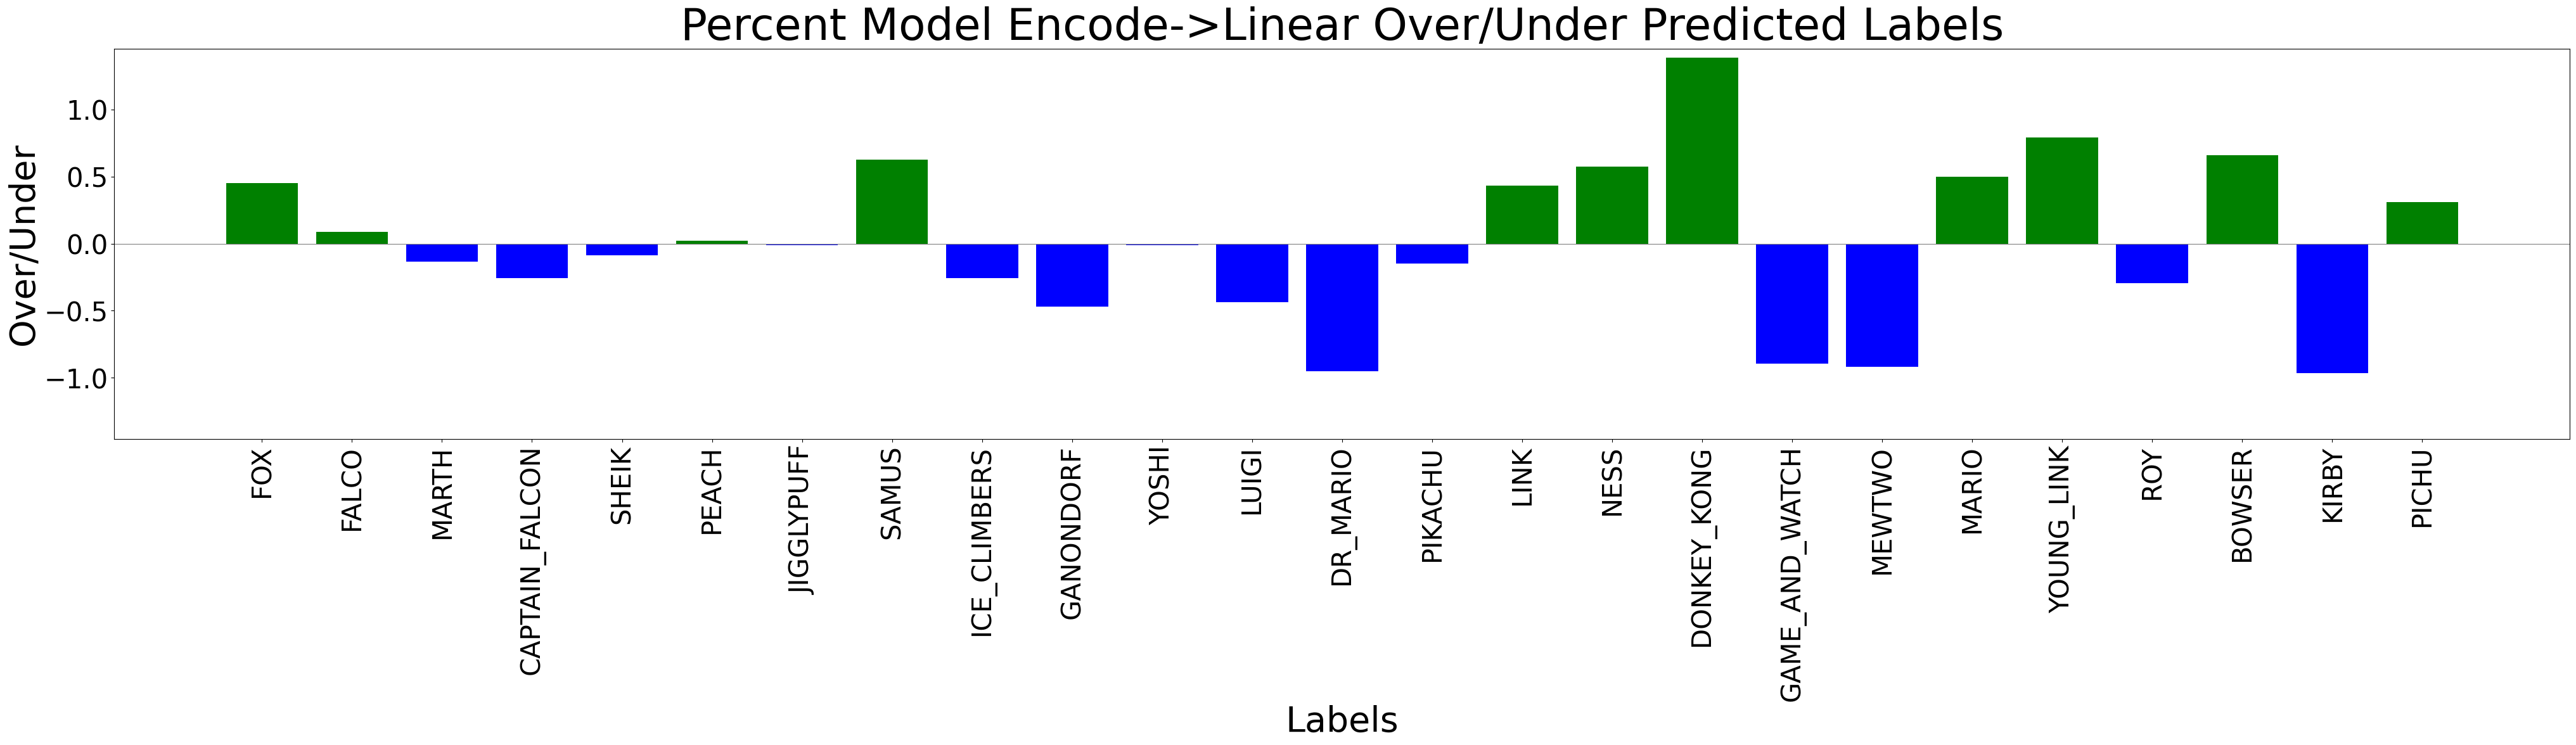

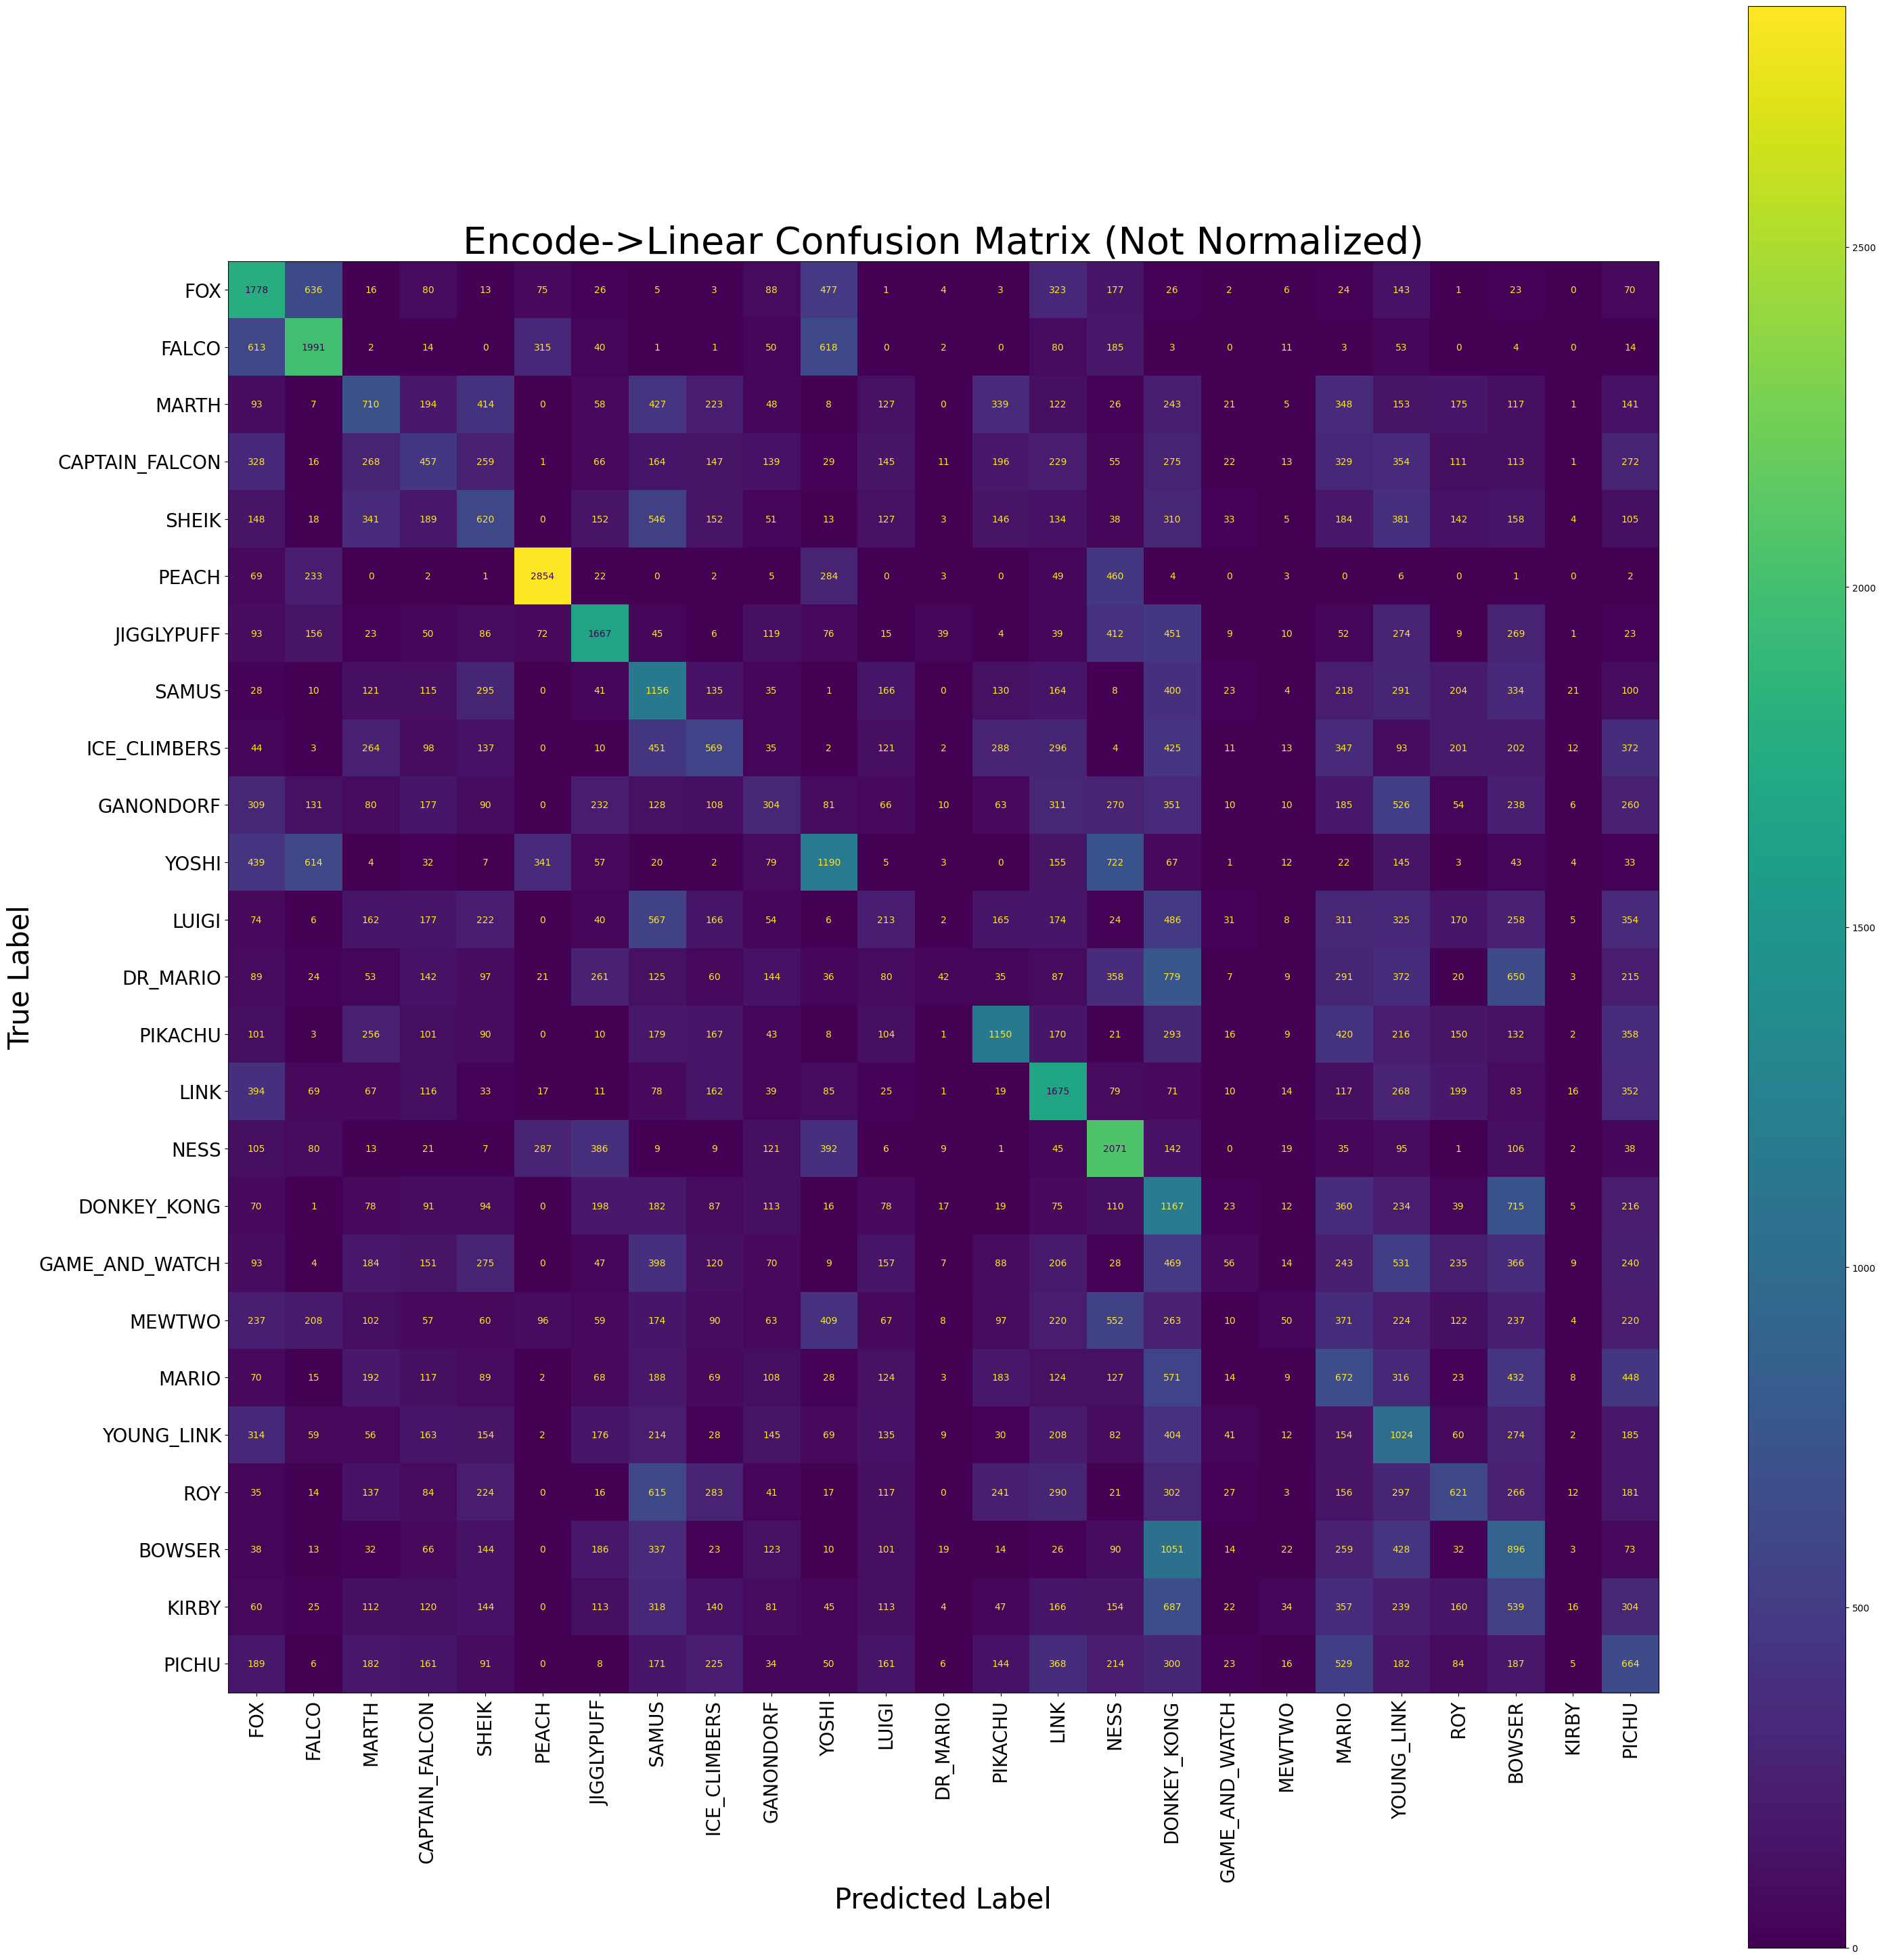

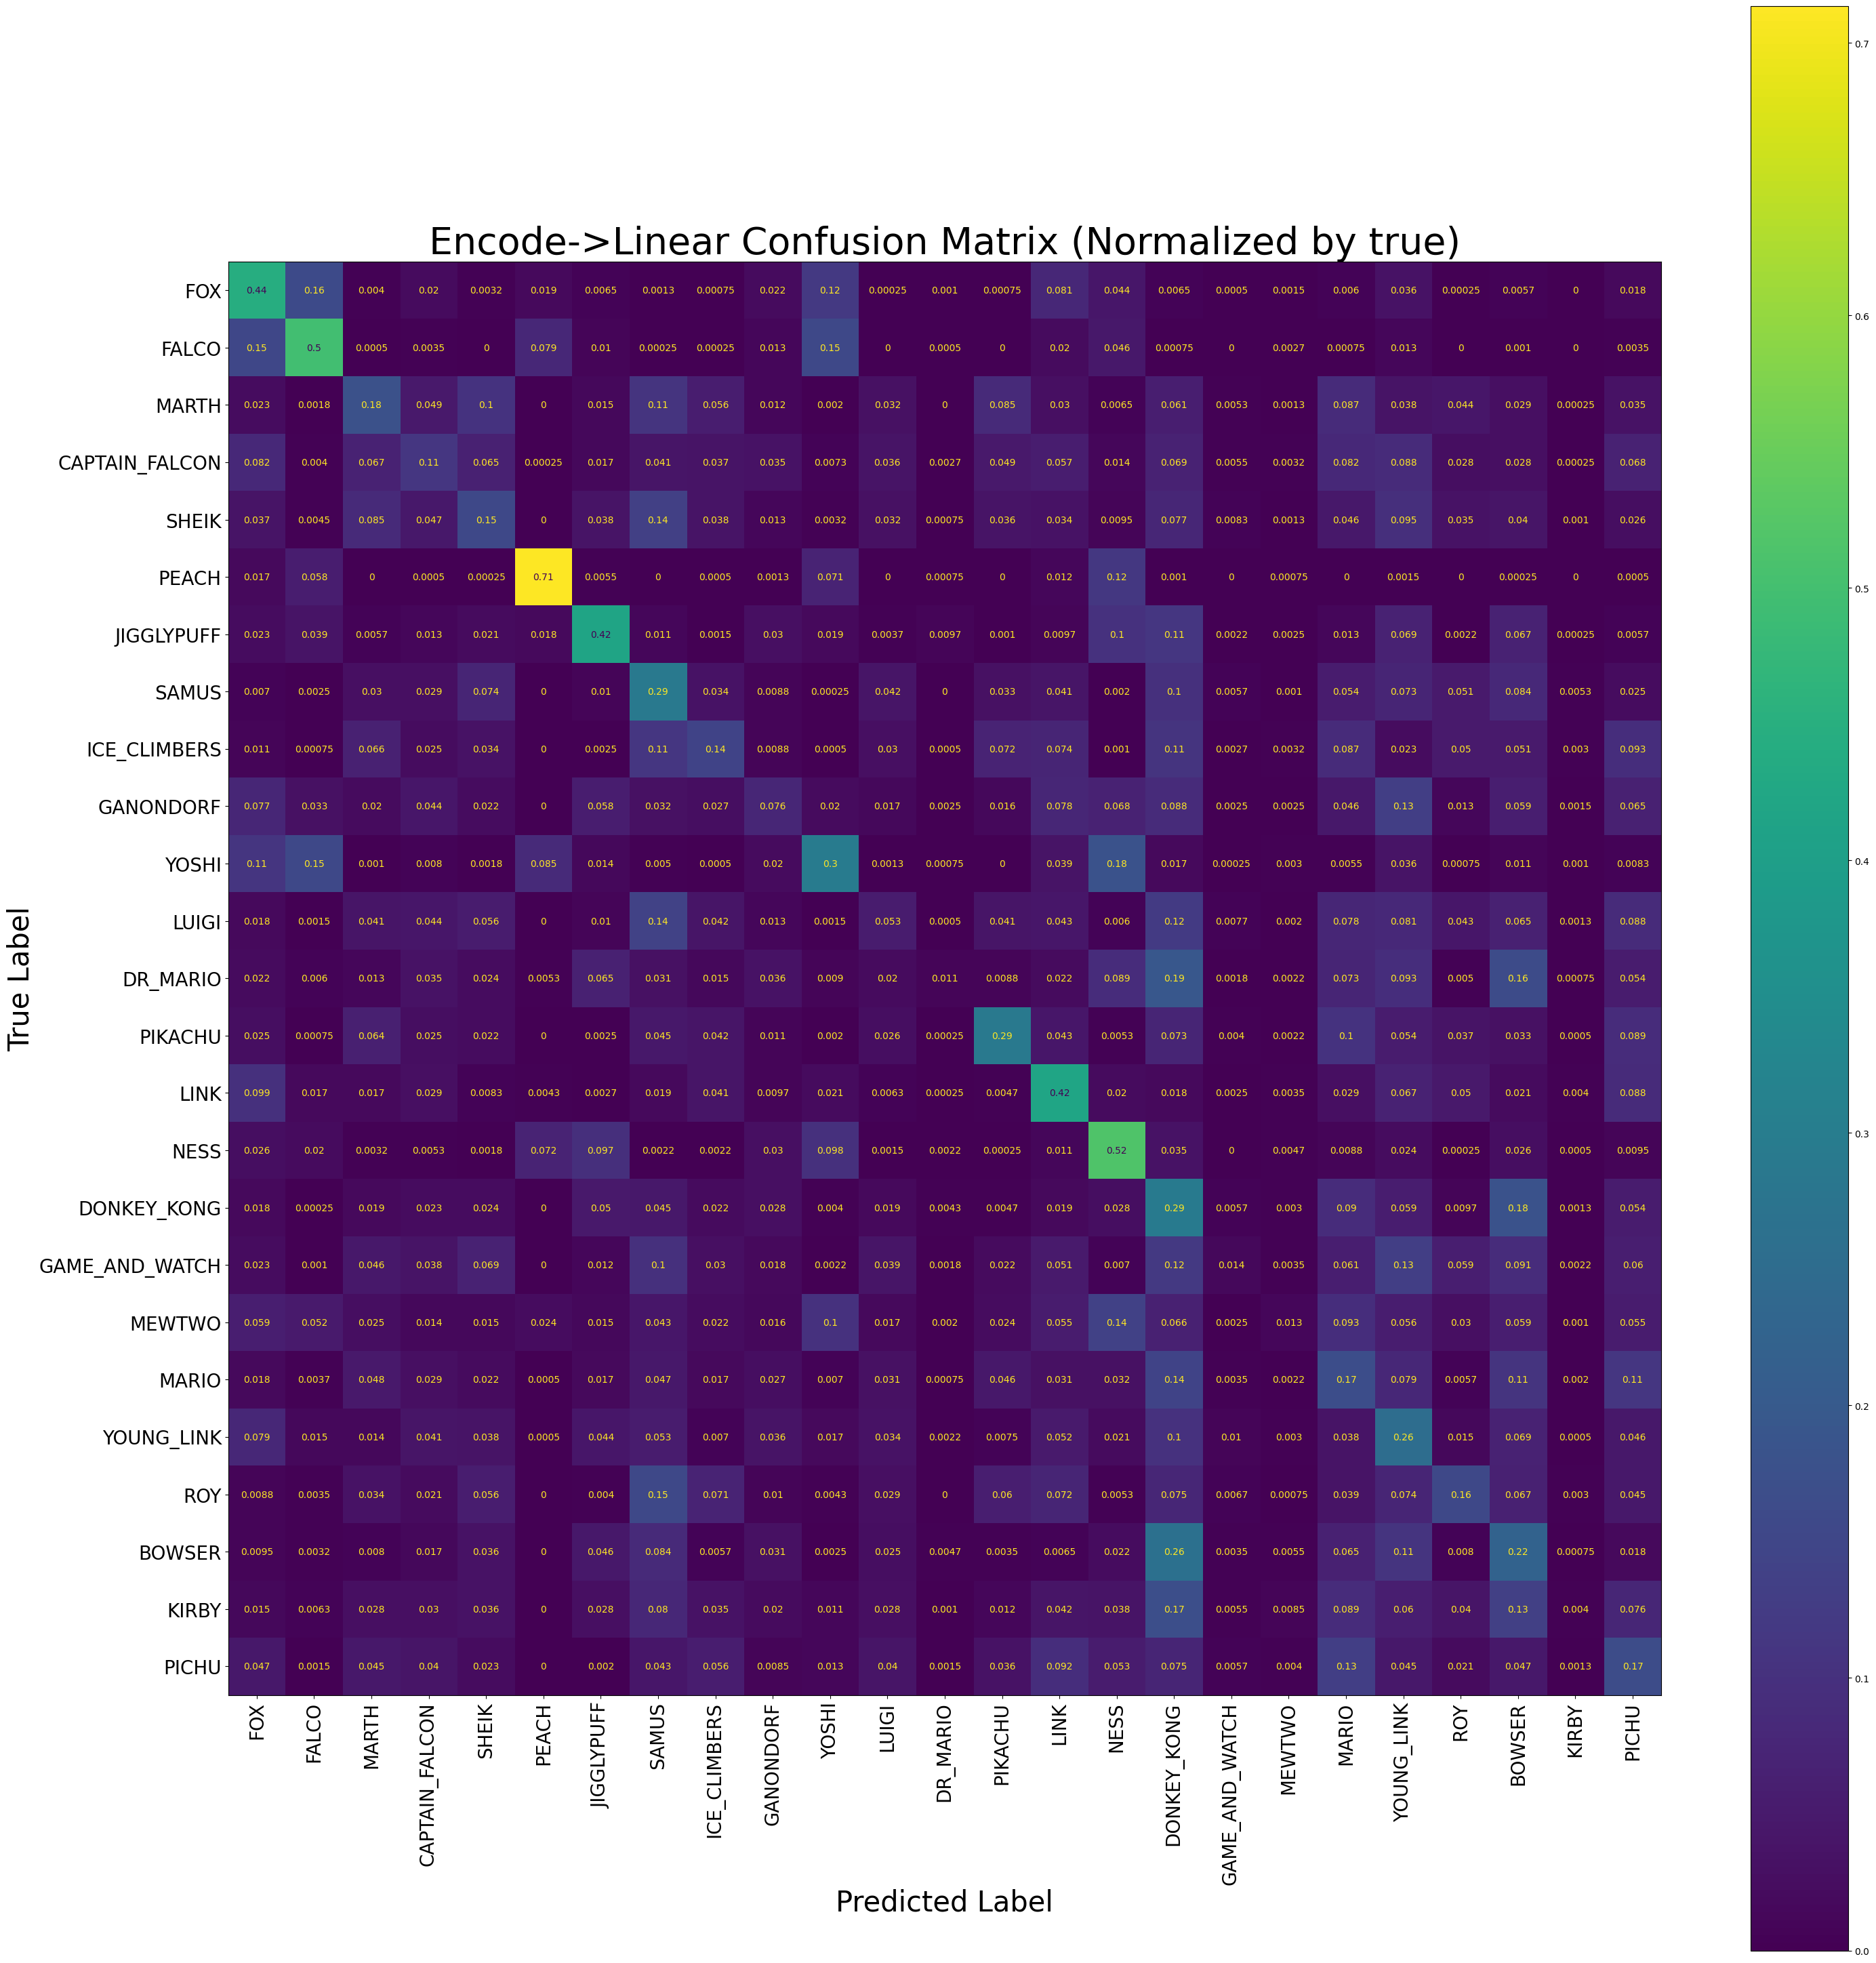

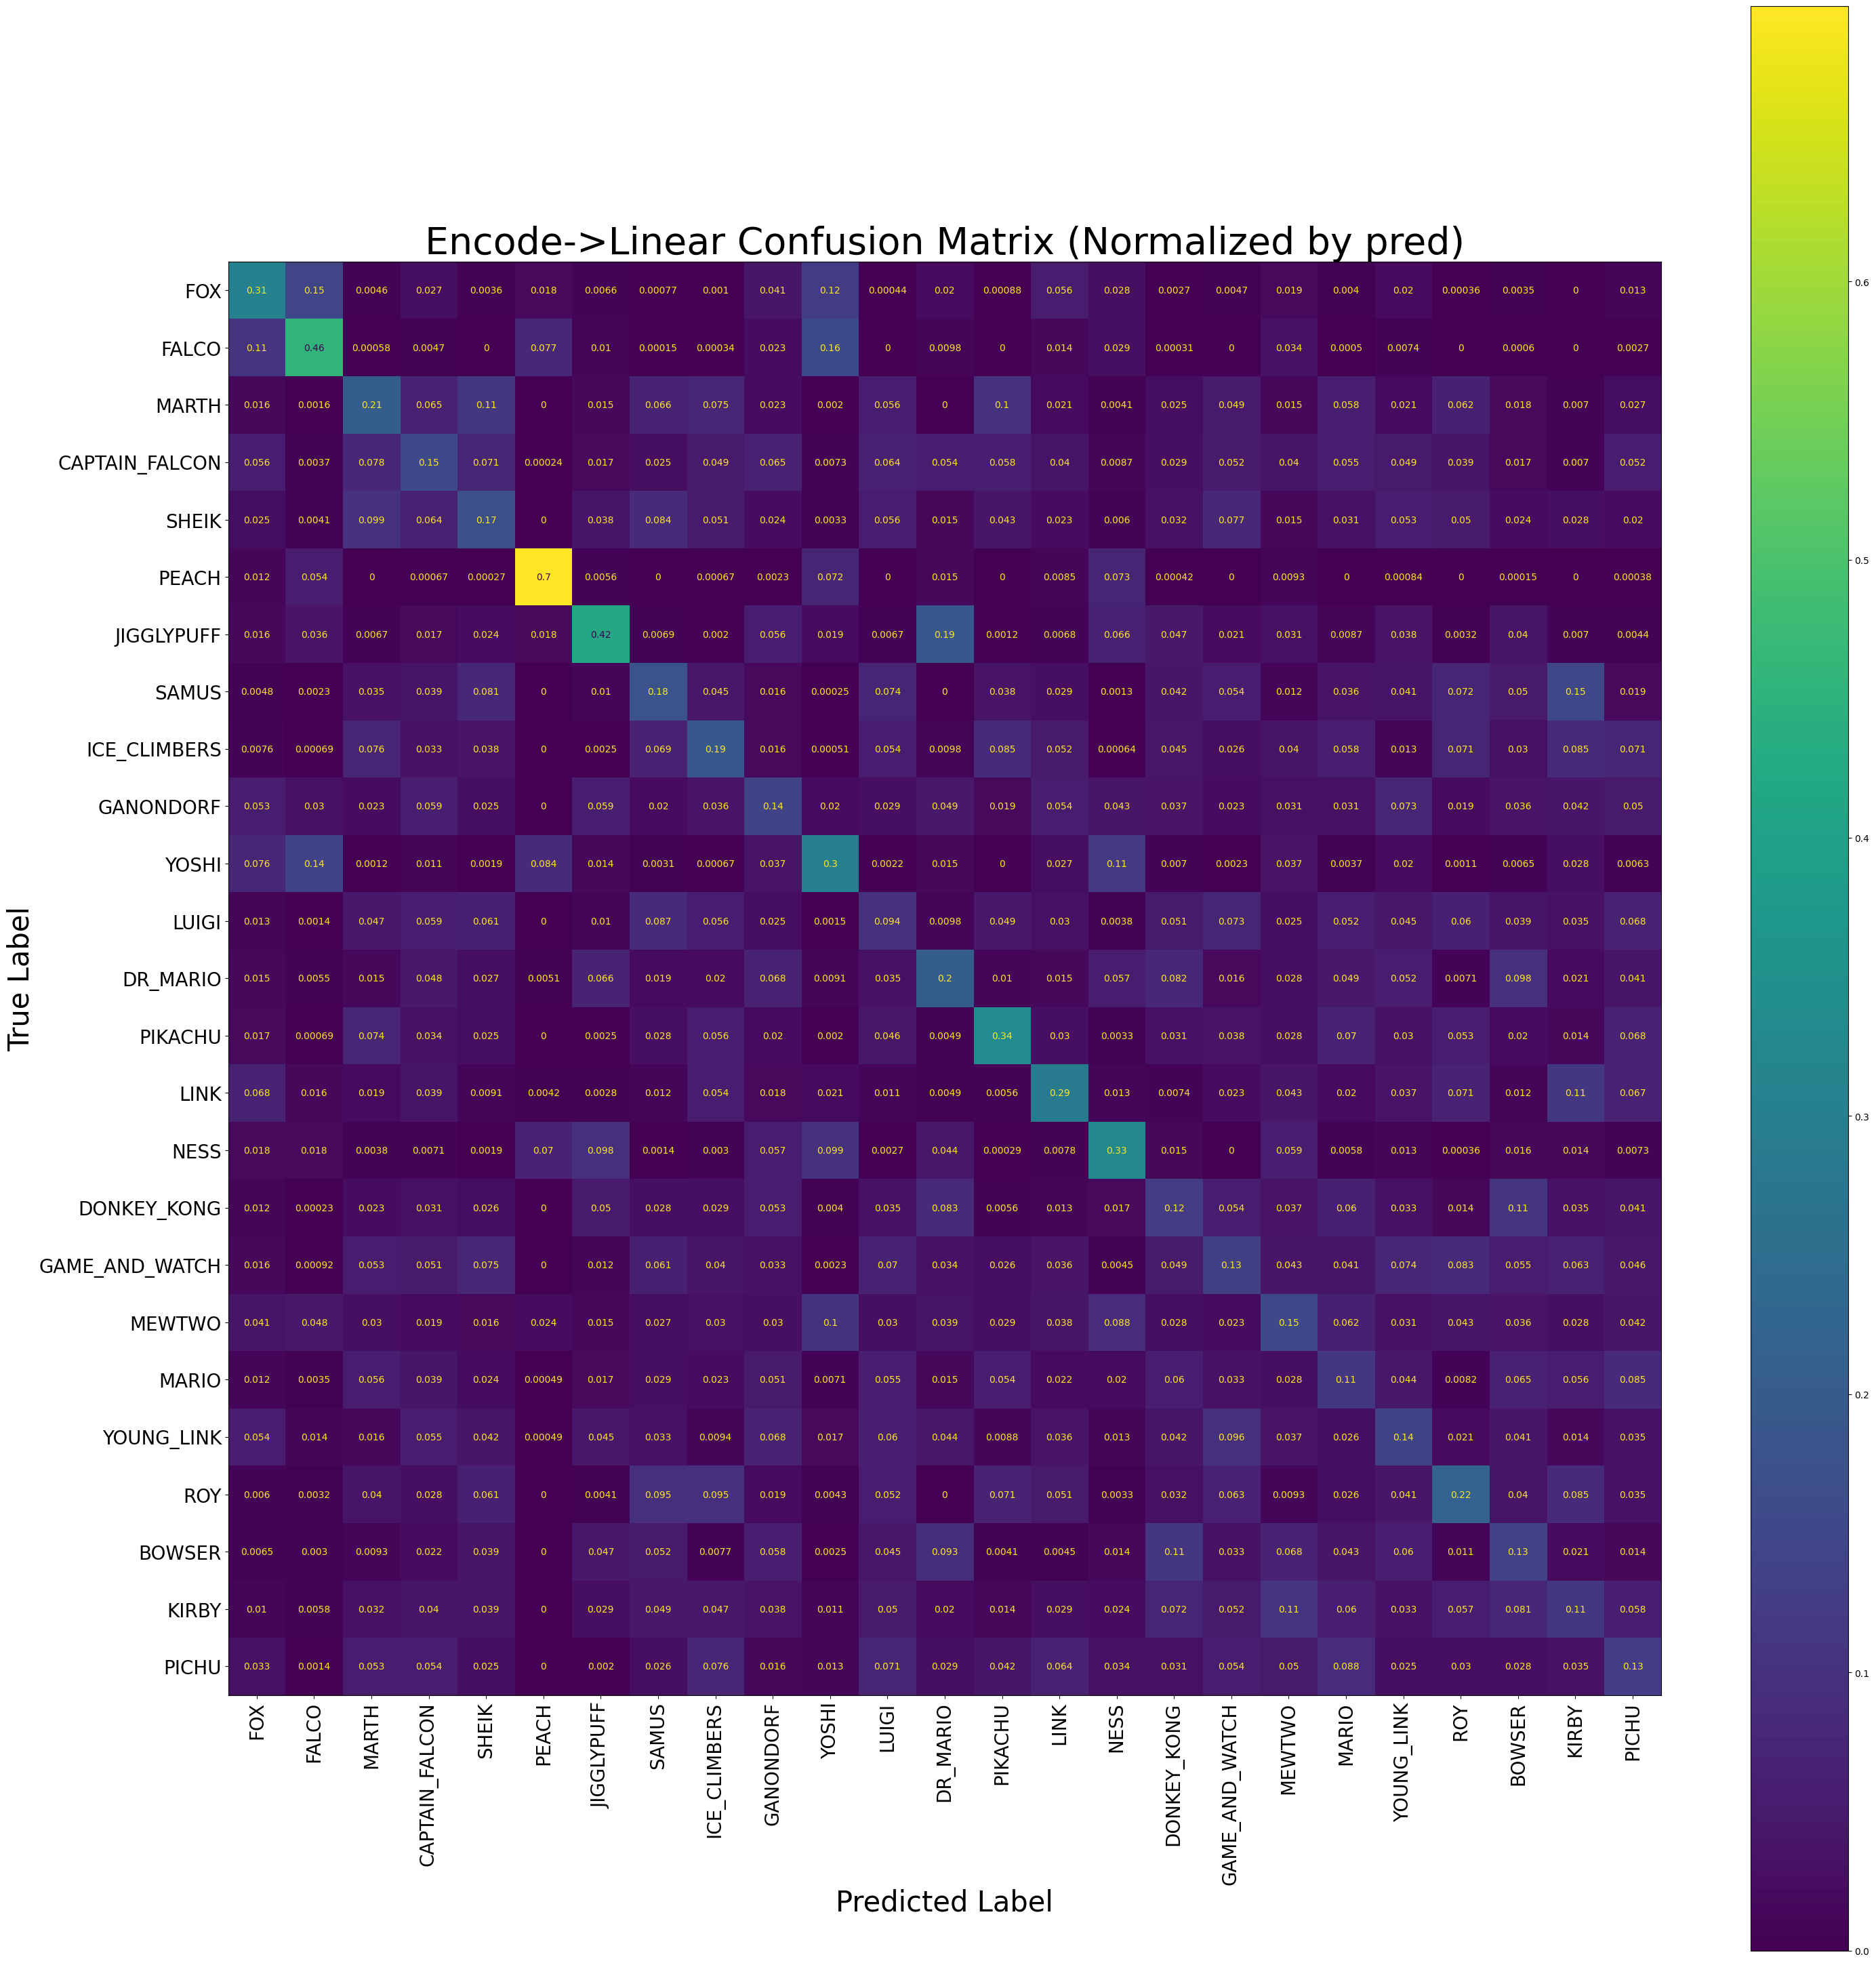

In [16]:
asses_model('Encode->Linear', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)